# Work In Progress

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns
# ---------
from msapy import msa, utils as ut
# ---------
from functools import partial
from typing import Union, Optional, List
from itertools import product
from collections import defaultdict, Counter

import bct
from netneurotools import cluster
import pandas as pd

from IPython.display import HTML

from sklearn.manifold import TSNE
import seaborn as sns

CM = 1 / 2.54
SEED = 42
RNG = np.random.default_rng(SEED)

/home/shrey/miniconda3/envs/msa/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision.utils as vutils
import torchvision.models as models


from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation
torch.manual_seed(SEED)

In [4]:
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

In [5]:
# Generator Code
class ConvTranspose2dLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size = 4, stride = 1, padding = 0, output_padding = 0, groups: int = 1, bias: bool = True):
        super(ConvTranspose2dLayer, self).__init__()
        self.seq = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding, groups, bias),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )
    
    def forward(self, input):
        return self.seq(input)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        first_layer = ConvTranspose2dLayer(nz, ngf * 16, 4, 1, 0, bias=False)
        middle_layers = []
        for i in range(4, 0, -1):
            middle_layers.append(ConvTranspose2dLayer(ngf * 2**(i), ngf * 2**(i-1), 4, 2, 1, bias=False))
        last_layer = nn.Sequential(nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False), nn.Sigmoid())
        self.model = nn.Sequential(first_layer, *middle_layers, last_layer)

    def forward(self, input, lesion_dict = None):
        lesion_dict = lesion_dict if lesion_dict else defaultdict(list)
        x = input
        for i, layer in enumerate(self.model):
            x = layer(x)
            if i in lesion_dict:
                x[:, lesion_dict[i]] = 0
        
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [6]:
netG = Generator()
netG.load_state_dict(torch.load("model_GAN_Face.pth", map_location=torch.device('cpu')))
netG.eval();

In [7]:
fixed_noise = torch.load("fixed_noise_face_gan.t")

In [8]:
import pickle as pkl

with open('save_face.pkl', 'rb') as fp:
    shapley_modes = pkl.load(fp)

In [9]:
shapley_modes.values.reshape((32, 3, 128, 128, -1))[0].transpose((3, 1, 2, 0)).shape

(1987, 128, 128, 3)

In [10]:
lesion_dict = defaultdict(list)
for x, y in shapley_modes.columns:
    lesion_dict[x].append(y)

In [49]:
corelation_matrix = pd.DataFrame(shapley_modes[[x for x in shapley_modes.columns if x[0]==layer]]).corr()

In [50]:
nonegative = np.abs(corelation_matrix.values.copy())
#nonegative = np.maximum(0, corelation_matrix.values.copy())

#ci, Q = bct.community_louvain(nonegative, gamma=1.5)
ci = [bct.community_louvain(nonegative, gamma=1.5, seed=n)[0] for n in range(100)]

consensus = cluster.find_consensus(np.column_stack(ci), seed=1234)
num_ci = len(np.unique(consensus))
y = np.bincount(consensus)
ii = np.nonzero(y)[0]
list(zip(ii,y[ii])) 

[(1, 14),
 (2, 7),
 (3, 14),
 (4, 14),
 (5, 12),
 (6, 12),
 (7, 18),
 (8, 6),
 (9, 6),
 (10, 13),
 (11, 5),
 (12, 7)]

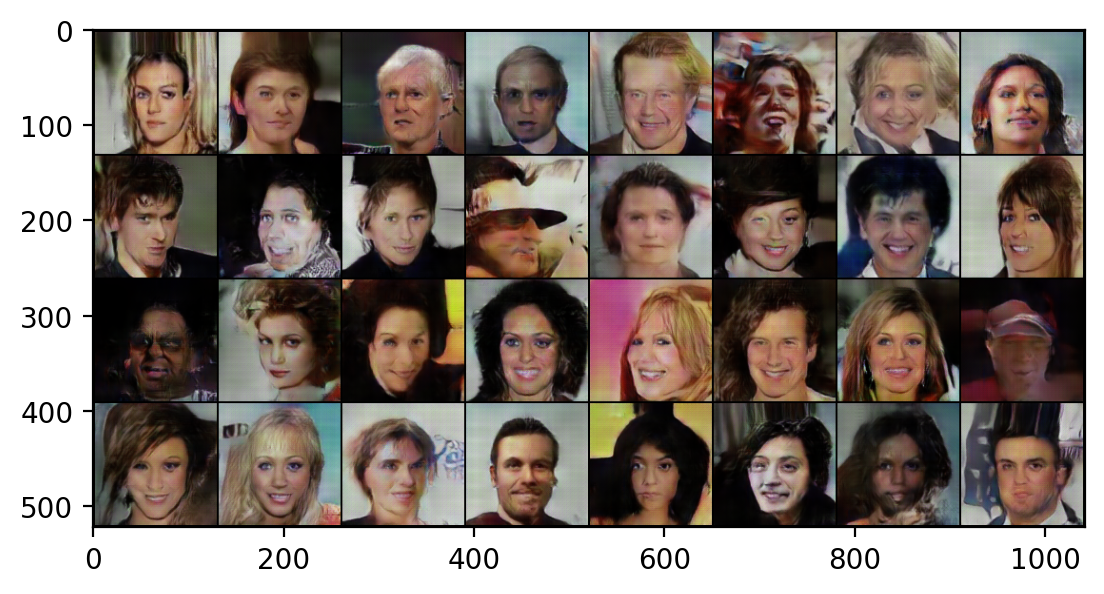

In [36]:
out = netG(fixed_noise.to("cpu"), {})
plt.figure(dpi=200)
plt.imshow(np.transpose(vutils.make_grid(out.cpu(), padding=2),(1,2,0)))

### Details in Faces

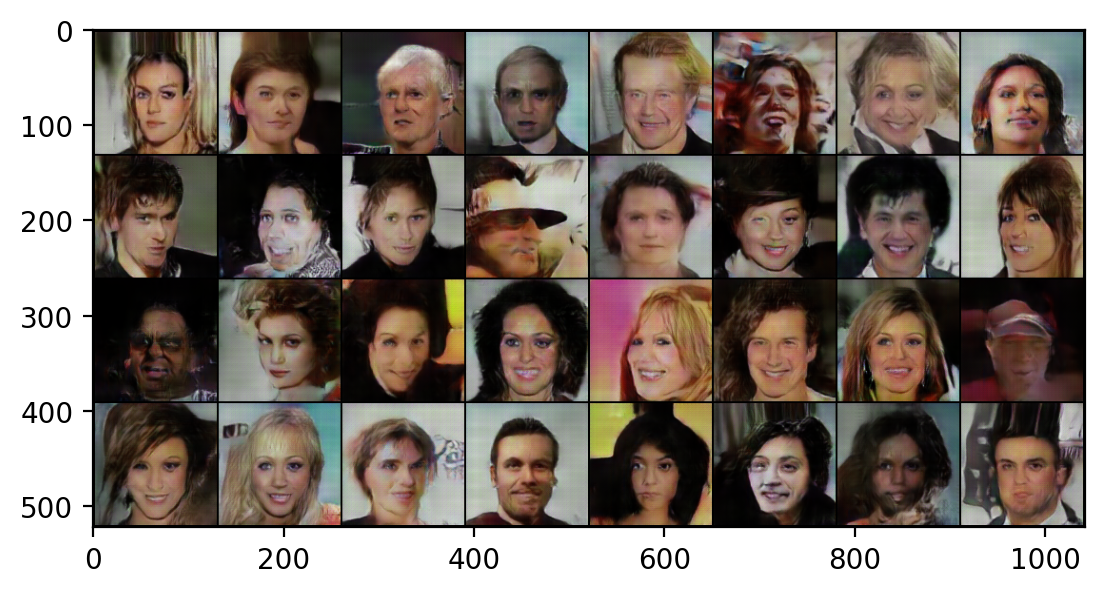

In [61]:
out = netG(fixed_noise.to("cpu"), {layer: np.where((consensus==11))})
plt.figure(dpi=200)
plt.imshow(np.transpose(vutils.make_grid(out.cpu(), padding=2),(1,2,0)))

In [11]:
def get_layer_contributions(layer):
    layer_contrib = []
    min_val = shapley_modes.values.min()

    for x, y in shapley_modes.columns:
        if x == layer:
            layer_contrib.append(torch.Tensor(shapley_modes.get_shapley_mode((x, y))) - min_val)
    return layer_contrib

MovieWriter imagemagick unavailable; using Pillow instead.


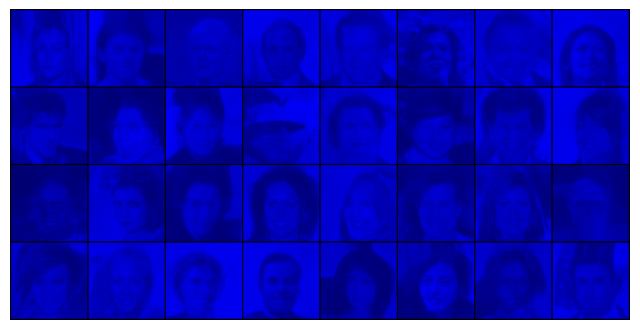

In [25]:
layer = 5

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(i), padding=2, normalize=True),(1,2,0)), animated=True)] for i in get_layer_contributions(layer)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

ani.save('animation.gif', writer='imagemagick', fps=1)

Animation size has reached 21075928 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
MovieWriter imagemagick unavailable; using Pillow instead.


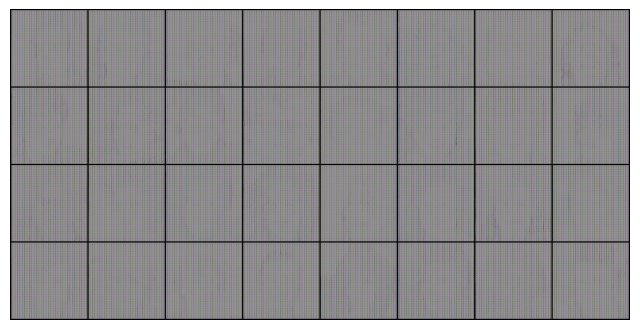

In [26]:
layer = 4

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(i), padding=2, normalize=True),(1,2,0)), animated=True)] for i in get_layer_contributions(layer)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

ani.save('animation.gif', writer='imagemagick', fps=1)

Animation size has reached 20977750 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
MovieWriter imagemagick unavailable; using Pillow instead.


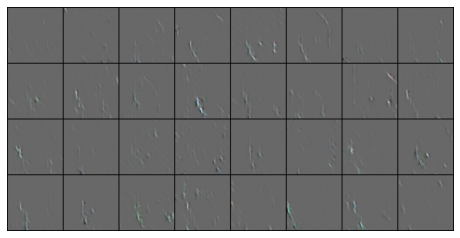

In [103]:
layer = 2

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(i), padding=2, normalize=True),(1,2,0)), animated=True)] for i in get_layer_contributions(layer)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())
ani.save('animation.gif', writer='imagemagick', fps=1)

Animation size has reached 21098213 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
MovieWriter imagemagick unavailable; using Pillow instead.


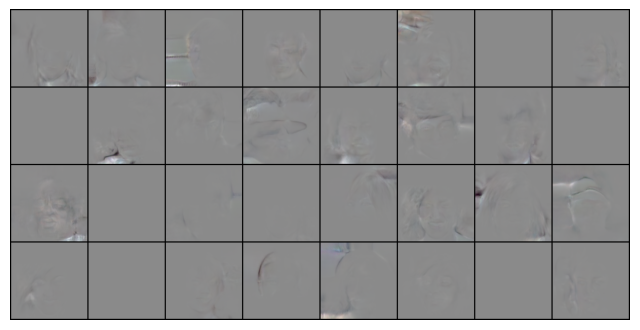

In [27]:
layer = 0

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(i), padding=2, normalize=True),(1,2,0)), animated=True)] for i in get_layer_contributions(layer)]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())
ani.save('animation.gif', writer='imagemagick', fps=3)

In [27]:
face_id = 22

In [73]:
from scipy.spatial.distance import pdist, cosine
from image_similarity_measures.quality_metrics import psnr, fsim, uiq

import dask
from dask.diagnostics import ProgressBar
import dask.array as da
from tqdm import tqdm

In [70]:
def dist_func(u, v):
    return uiq(u.reshape((128, 128, 3)), v.reshape((128, 128, 3)))

In [74]:
face_contrib = shapley_modes.values.reshape((32, 3, 128, 128, -1))[face_id].copy()
for i in range(face_contrib.shape[-1]):
    high = face_contrib[..., i].max((1 , 2), keepdims = True)
    low = face_contrib[..., i].min((1 , 2), keepdims = True)
    face_contrib[..., i] = (face_contrib[..., i] - low) / (high - low)
face_contrib = face_contrib.reshape((3*128*128, -1))

matrix = np.zeros((face_contrib.shape[1], face_contrib.shape[1]))
for i in tqdm(range(matrix.shape[0] - 1)):
    for j in range(i+1, matrix.shape[0]):
        matrix[i, j] = cosine(face_contrib[:, i], face_contrib[:, j])

100%|██████████| 1986/1986 [07:13<00:00,  4.58it/s] 


[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 1987 samples in 0.226s...
[t-SNE] Computed neighbors for 1987 samples in 1.542s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1987
[t-SNE] Computed conditional probabilities for sample 1987 / 1987
[t-SNE] Mean sigma: 0.074252
[t-SNE] KL divergence after 50 iterations with early exaggeration: 40.397686
[t-SNE] KL divergence after 1000 iterations: 0.578948


[Text(0.5, 1.0, 'Shapley Modes T-SNE Single Face')]

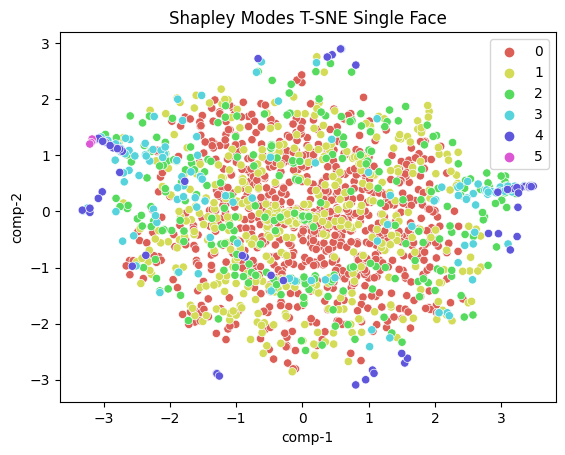

In [14]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, perplexity=500)
z = tsne.fit_transform(face_contrib.T) 

df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue = [a[0] for a in shapley_modes.columns],
                palette=sns.color_palette("hls", 6),
                data=df).set(title="Shapley Modes T-SNE Single Face") 

1.0 0.0
[t-SNE] Computing 1501 nearest neighbors...
[t-SNE] Indexed 1987 samples in 18.744s...
[t-SNE] Computed neighbors for 1987 samples in 44.086s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1987
[t-SNE] Computed conditional probabilities for sample 1987 / 1987
[t-SNE] Mean sigma: 96.310672
[t-SNE] KL divergence after 50 iterations with early exaggeration: 44.036026
[t-SNE] KL divergence after 650 iterations: 0.429707


[Text(0.5, 1.0, 'Shapley Modes T-SNE')]

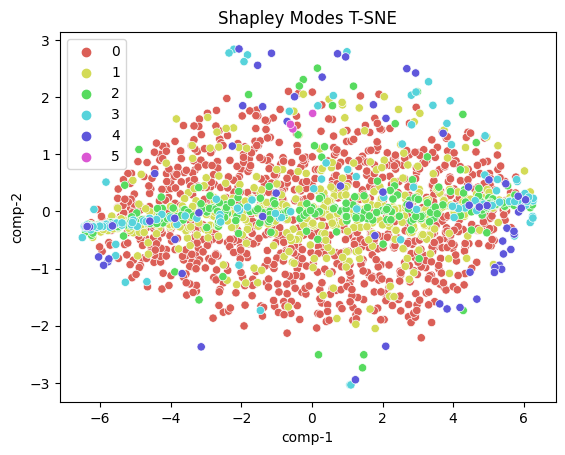

In [13]:
shapley_modes_copy = shapley_modes.values.copy()

for face_id in range(32):
    face_contrib = shapley_modes_copy.reshape((32, 3, 128, 128, -1))[face_id]
    for i in range(face_contrib.shape[-1]):
        high = face_contrib[..., i].max((1 , 2), keepdims = True)
        low = face_contrib[..., i].min((1 , 2), keepdims = True)
        face_contrib[..., i] = (face_contrib[..., i] - low) / (high - low)
    #face_contrib = face_contrib.reshape((3*128*128, -1))
    shapley_modes_copy.reshape((32, 3, 128, 128, -1))[face_id] = face_contrib

print(shapley_modes_copy.max(), shapley_modes_copy.min())

tsne = TSNE(n_components=2, verbose=1, random_state=123,  perplexity=500)
z = tsne.fit_transform(shapley_modes_copy.T) 

df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue = [a[0] for a in shapley_modes.columns],
                palette=sns.color_palette("hls", 6),
                data=df).set(title="Shapley Modes T-SNE") 

In [15]:
corelation_matrix = np.corrcoef(face_contrib.T)

In [77]:
nonegative = np.abs(matrix.copy())
#nonegative = np.maximum(0, corelation_matrix.copy())
#nonegative = corelation_matrix.copy() + 1

#ci, Q = bct.community_louvain(nonegative, gamma=1.5)
ci = [bct.community_louvain(nonegative, gamma=1, seed=n)[0] for n in range(100)]

consensus = cluster.find_consensus(np.column_stack(ci), seed=1234)
num_ci = len(np.unique(consensus))
y = np.bincount(consensus)
ii = np.nonzero(y)[0]
list(zip(ii,y[ii])) 

[(1, 1), (2, 1986)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


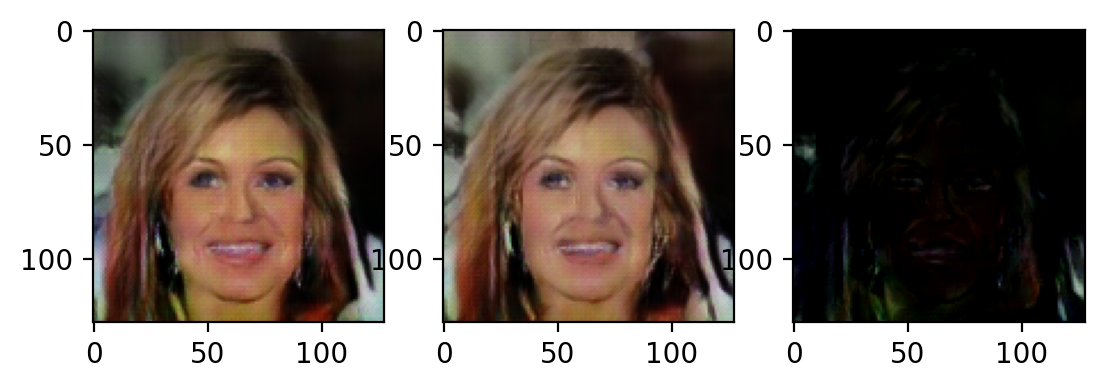

In [32]:
out_unlesioned = netG(fixed_noise[face_id][None].to("cpu"), {}).detach().squeeze()
figure, axis = plt.subplots(1, 3)
figure.set_dpi(200)
axis[0].imshow(np.transpose(out_unlesioned.cpu(),(1,2,0)))

lesion_dict = defaultdict(list)
for layer, neuron in shapley_modes.columns[consensus==15]:
    lesion_dict[layer].append(neuron)

out_lesioned = netG(fixed_noise[face_id][None].to("cpu"), lesion_dict).detach().squeeze()
axis[1].imshow(np.transpose(out_lesioned.cpu(),(1,2,0)))

out_diff = out_unlesioned - out_lesioned
axis[2].imshow(np.transpose(out_diff.cpu(),(1,2,0)))

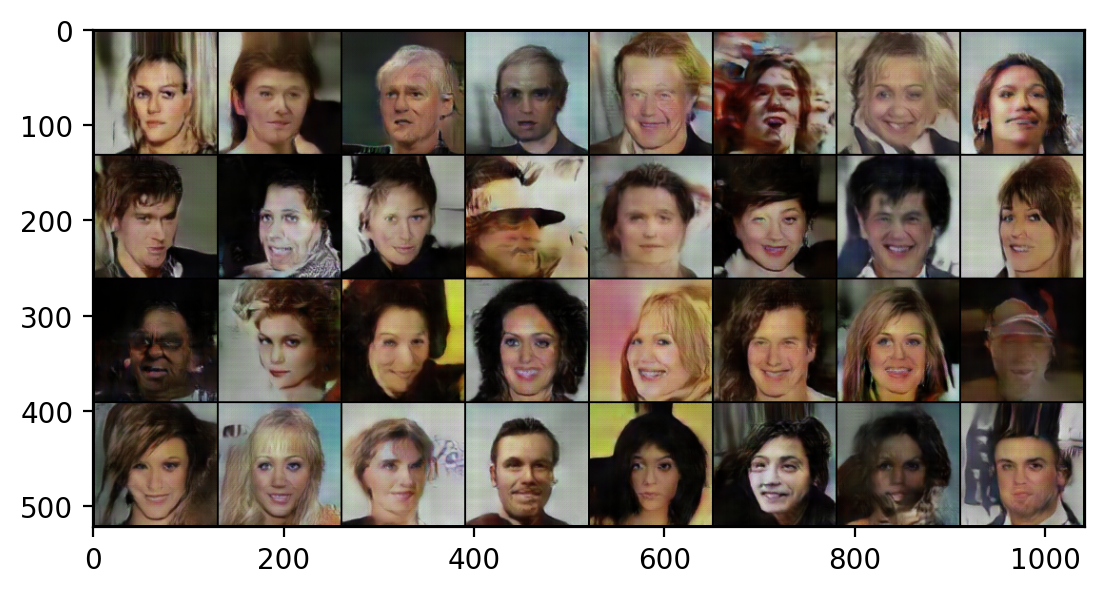

In [28]:
lesion_dict = defaultdict(list)
for layer, neuron in shapley_modes.columns[consensus==11]:
    lesion_dict[layer].append(neuron)

out = netG(fixed_noise.to("cpu"), lesion_dict)
plt.figure(dpi=200)
plt.imshow(np.transpose(vutils.make_grid(out.cpu(), padding=2),(1,2,0)))

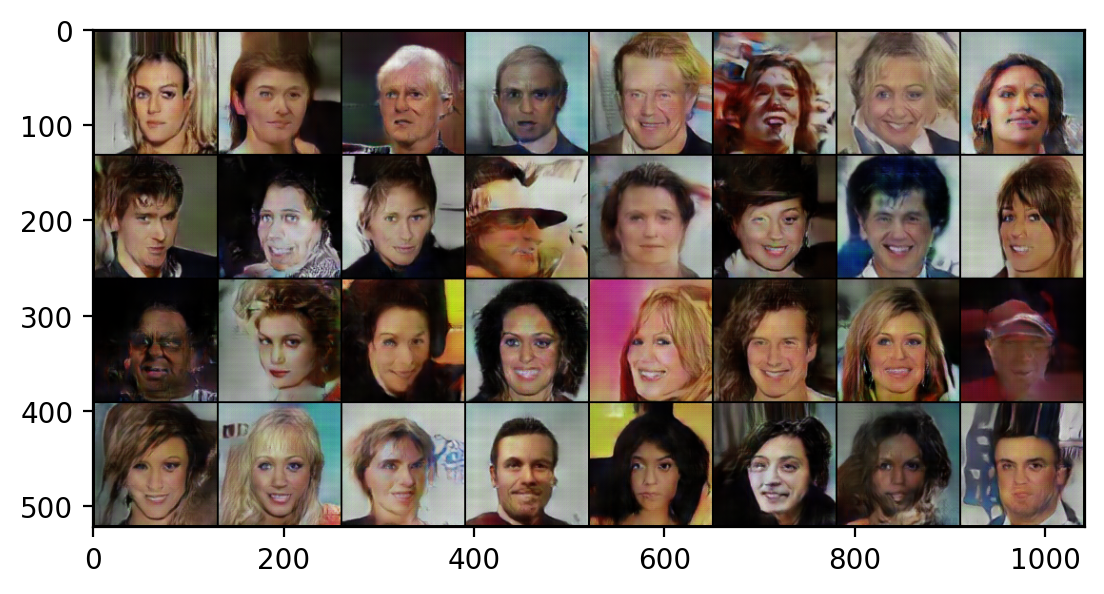

In [114]:
out = netG(fixed_noise.to("cpu"), {})
plt.figure(dpi=200)
plt.imshow(np.transpose(vutils.make_grid(out.cpu(), padding=2),(1,2,0)))

In [110]:
face_id = 19
face_contrib = shapley_modes.values.reshape((32, 3, 128, 128, -1))[face_id].reshape(3*128*128, -1)
corelation_matrix = np.corrcoef(face_contrib.T)
nonegative = np.abs(corelation_matrix.copy())
#nonegative = np.maximum(0, corelation_matrix.copy())

#ci, Q = bct.community_louvain(nonegative, gamma=1.5)
ci = [bct.community_louvain(nonegative, gamma=1.5, seed=n)[0] for n in range(100)]

consensus = cluster.find_consensus(np.column_stack(ci), seed=1234)
num_ci = len(np.unique(consensus))
y = np.bincount(consensus)
ii = np.nonzero(y)[0]
list(zip(ii,y[ii])) 

[(1, 119),
 (2, 179),
 (3, 207),
 (4, 338),
 (5, 313),
 (6, 224),
 (7, 136),
 (8, 92),
 (9, 379)]

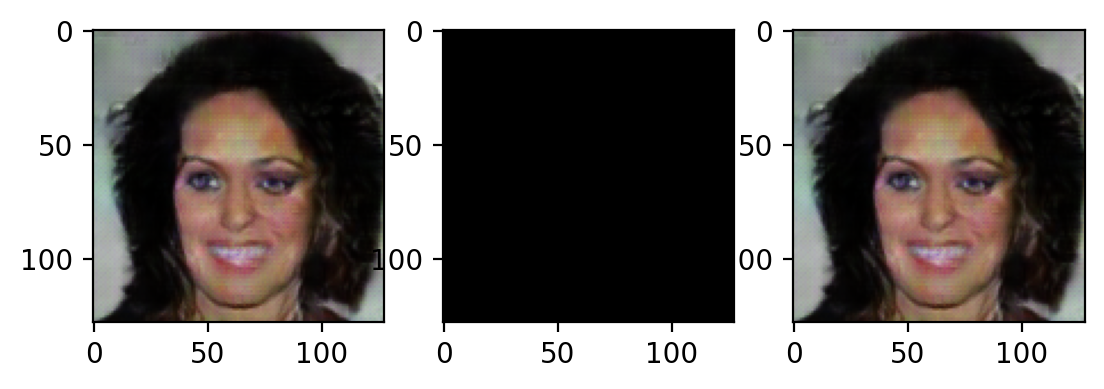

In [133]:
out_unlesioned = netG(fixed_noise[face_id][None].to("cpu"), {}).detach()[0]
figure, axis = plt.subplots(1, 3)
figure.set_dpi(200)
axis[0].imshow(np.transpose(out_unlesioned.cpu(),(1,2,0)))

lesion_dict = defaultdict(list)
for layer, neuron in shapley_modes.columns[consensus==9]:
    lesion_dict[layer].append(neuron)

out_lesioned = netG(fixed_noise[face_id][None].to("cpu"), lesion_dict).detach().squeeze()
axis[1].imshow(np.transpose(out_lesioned.cpu(),(1,2,0)))

out_diff = out_unlesioned - out_lesioned
axis[2].imshow(np.transpose(out_diff.cpu(),(1,2,0)))

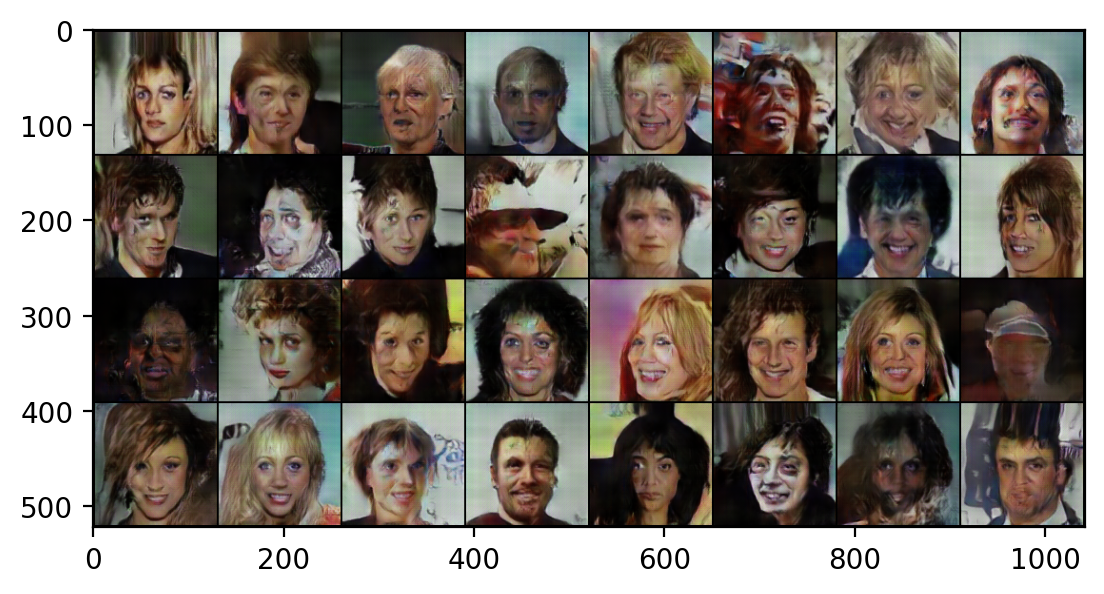

In [132]:
out = netG(fixed_noise.to("cpu"), lesion_dict)
plt.figure(dpi=200)
plt.imshow(np.transpose(vutils.make_grid(out.cpu(), padding=2),(1,2,0)))